# The Business of Death Care

(Due to NDA clause, I have anonymized any identifying features**)


When I put out some feelers for businesses that would want some data analytics work done, a friend volunteered their company's data with a caveat - "it's in the death care business...let me know if that's too weird for you." 

The death care business is one of those industries that never crosses your mind until someone tells you about it. A quick wikipedia search surfaces some interesting albeit macabre facts: it is a $16 billion industry and the amount of embalding fluid buried every year is enough to fill eight Olympic size pools!

My client's death care company specializes in selling a product for mausoleums (in the interest of anonymity, I won't specify what that product is). They sell B2B, primarily to funeral homes, with concentrated clients on the coast. It's family business and has been around for 20 years - which means they have 20 years worth of financial data across 700 different clients. 

With this in mind, I decided to try a time series analysis on the data to see if I could make a model that could accurately forecast future revenue. 

Let's get started!

# Loading the Data

In [990]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib.style as style
style.use('fivethirtyeight')

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, AR, ARIMA
import statsmodels.api as sm

from fbprophet import Prophet


The data came in two datasets of monthly sales stretching from 1994-2017. I decided to only use the 2000-2017 dataset.

In [1207]:
monthly_sales_00_17 = pd.read_csv('removed for nda purposes')


# EDA!

The first thing that needed to be done to this dataset was to clean it. It came from quickbooks so formatting was not easy. I dropped a bunch of rows, reset indexes, renamed columns, got rid of nulls, extracted phone number to use as the customer_id, and most importantly converted the dates to datetime objects so it could be easily fed into a time series model. 

In [1209]:
#the cleaner function takes in the dataframe that you'd like cleaned and returns a cleaned dataframe

def cleaner(df):
    #drop first 3 lines
    df.columns = df.iloc[3,:]
    
    #reset index
    df_clean = df.iloc[4:,:].reset_index(drop=True)
    
    #rename columns
    df_clean.rename(columns = {df_clean.columns[0]:'customers'}, inplace=True)
    
    df_clean.head()
    
    #get rid of nulls in customer column
    df_clean = df_clean[~df_clean['customers'].isnull()]
    
    #extract phone number 
    df_clean['cust_id'] = df_clean['customers'].str.extract('(\d{3}-\d{3}-\d{4})', expand = True)

    #clean object cells to prepare for conversion to floats
    df_clean = df_clean.apply(lambda x: x.str.replace(',', '').str.strip() if x.dtype == "object" else x)

    #fill NA columns with 0 
    df_clean.fillna(value=0, inplace = True) 
    
    #convert to float
    df_clean.iloc[:-2,1:-2] = df_clean.iloc[:-2, 1:-2].astype(float)
    
    return df_clean

#transforms the cleaner function into a class that has fit and transform method
cleaner_tf = FunctionTransformer(cleaner, validate = False)
df_00 = cleaner_tf.fit_transform(monthly_sales_00_17)

In [1210]:
#change column names to datetime objects
new_col_names = pd.to_datetime(df_00.columns[1:-2]).date

#create new dataframe of the months
new_df = df_00.iloc[:-2, 1:-2]

#rename those columns to datetime objects
new_df.columns = new_col_names

#concat customer and customer id to the new datetime object columns
df_00_clean = pd.concat([df_00[['customers', 'cust_id']], new_df], axis =1)


In [1211]:
df_00_clean = df_00_clean.iloc[:-2,:-1]

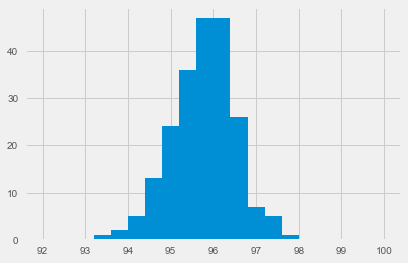

In [1213]:
#find how many zeros per column
percent_null_col = (1 - df_00_clean.astype(bool).sum(axis=0)/df_00_clean.shape[0])*100
plt.hist(percent_null_col[2:], bins=20, range = (92, 100));

count    214.000000
mean       4.229455
std        0.720209
min        2.275862
25%        3.793103
50%        4.137931
75%        4.689655
max        6.551724
dtype: float64

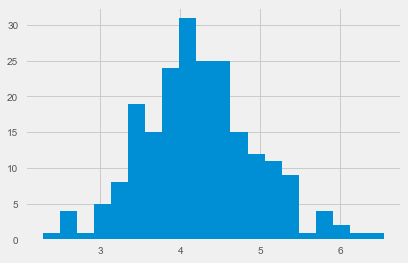

In [1214]:
#count of customer orders
num_cust_order_by_month = (df_00_clean.astype(bool).sum(axis=0)/df_00_clean.shape[0])*100
plt.figure(figsize=(6,4))
plt.hist(num_cust_order_by_month[2:], bins=20);
num_cust_order_by_month[2:].describe()



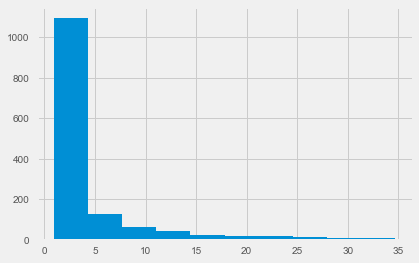

In [1215]:
#Percent null pper row
months_purchased_by_cust = (df_00_clean.astype(bool).sum(axis =1)/df_00_clean.shape[1])*100
plt.hist(months_purchased_by_cust[months_purchased_by_cust<35].sort_values(ascending =False));



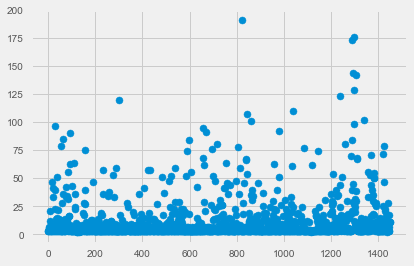

In [1216]:
total_purchases = df_00_clean.astype(bool).sum(axis=1)
plt.scatter(x = total_purchases.index, y = total_purchases);

In [1217]:
time_series_df = pd.DataFrame(df_00_clean.sum(axis = 0)[1:], columns = ['total_revenue'])
time_series_df.index = pd.to_datetime(time_series_df.reset_index()['index'])
time_series_df.head()

,total_revenue
index,
2000-01-01,237476
2000-02-01,91724.3
2000-03-01,139189
2000-04-01,203039
2000-05-01,113537


In [1223]:
#

time_series_df.total_revenue = time_series_df.total_revenue.astype(float)

In [1226]:
time_series_df.describe()

,total_revenue
count,214.000000
mean,138470.981542
std,36201.000829
min,74053.830000
25%,113264.132500
50%,130543.340000
75%,156521.385000
max,257879.360000


# Visualizing the Time Series

Finally, I have a clean dataset of monthly dates and the total revenue for that month!

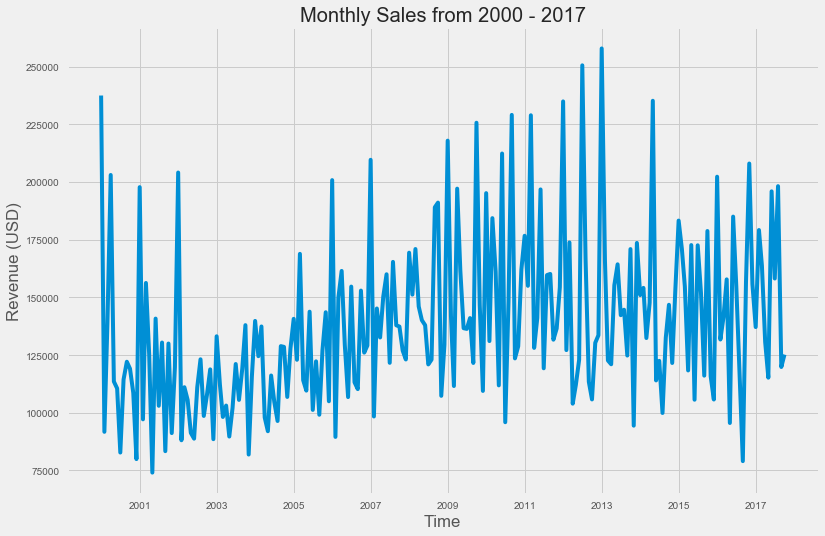

In [1228]:
plt.figure(figsize=(12,8))
plt.plot(time_series_df);
plt.title('Monthly Sales from 2000 - 2017')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')

That is super noisy, try taking quarterly and then 6 month samples to see if it'll change

(70, 1)

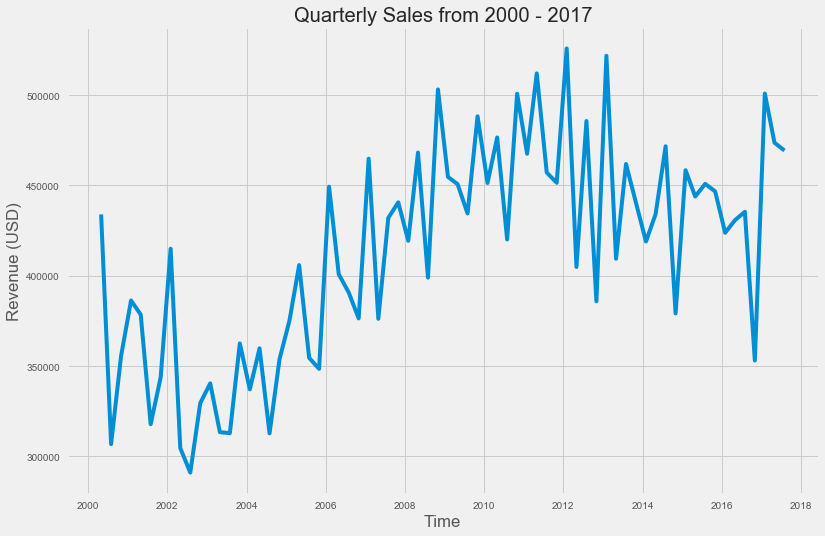

In [1229]:
quarterly = time_series_df.resample('3M').sum()
#get rid of start and end outliers 
quarterly = quarterly[1:-1]
plt.figure(figsize=(12,8))
plt.plot(quarterly)
plt.title('Quarterly Sales from 2000 - 2017')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')
quarterly.shape


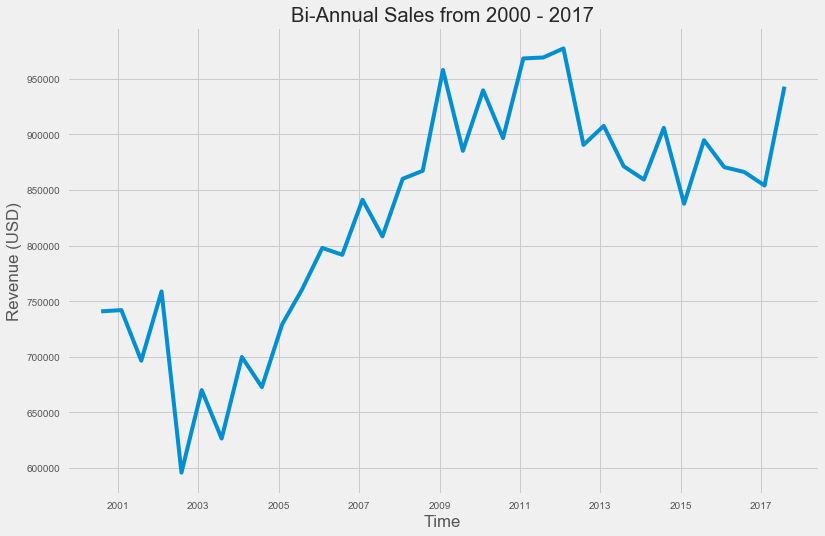

In [1235]:
#lets look at 6 month intervals

bi_yearly = time_series_df.resample('6M').sum()
bi_yearly = bi_yearly[1:-1]
plt.figure(figsize=(12,8))
plt.plot(bi_yearly);
plt.title('Bi-Annual Sales from 2000 - 2017')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')


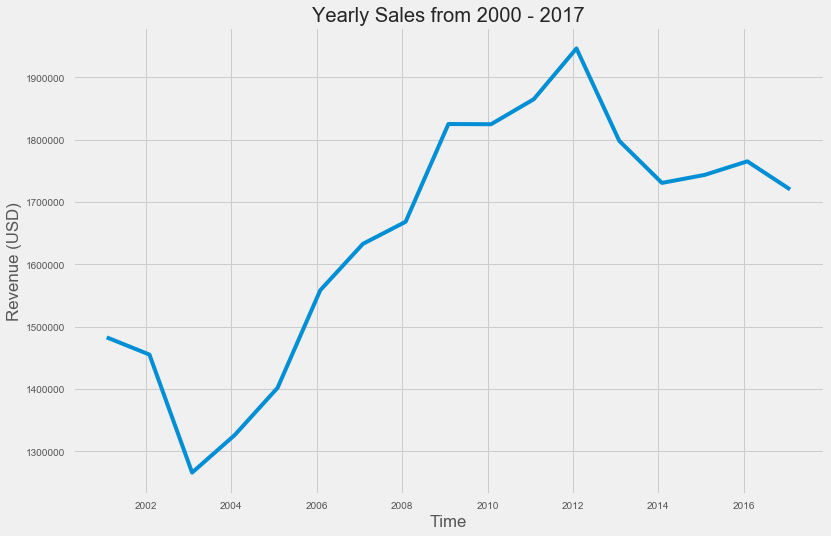

In [1237]:
yearly = time_series_df.resample('12M').sum()
yearly = yearly[1:-1]
plt.figure(figsize=(12,8));
plt.plot(yearly);
plt.title('Yearly Sales from 2000 - 2017')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')

Let's run seasonal decomposition to see the trend, seasonality, and error more easily. 

**The graphs below show:**
- The trend in sales increased from 2003 and 2011 and declined from 2011 - 2017. 
- There is a strong seasonality signal, seems like the beginning of every year, there is a spike in sales, and the end of every year there is a low. 
- The residual has high variance though is centered around 0.
- The data does not look stationary.



In [1238]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(series, time_type):
    total = series.total_revenue.groupby(series.index).sum()
    results = seasonal_decompose(total)
    plt.figure(figsize=(8,6))
    plt.plot(results.trend, label ="trend", lw=2)
    plt.plot(results.seasonal, label = "seasonality", lw =2)
    plt.title("Detecting {} Trend and Seasonality".format(time_type))
    plt.xlabel("Time")
    plt.ylabel("Revenue (USD)")
    return results

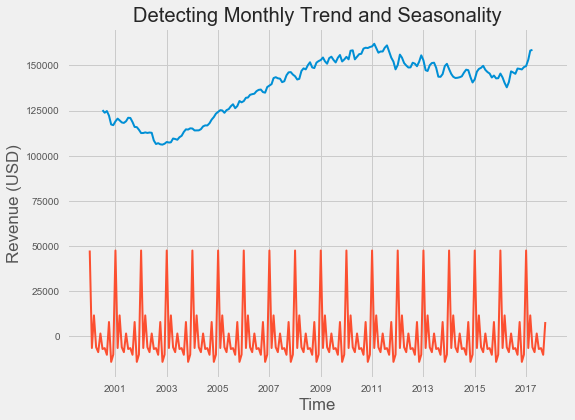

In [1239]:
decompose(time_series_df, "Monthly")

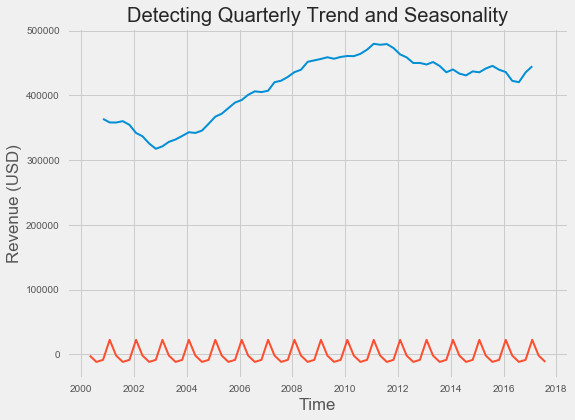

In [1240]:
decompose(quarterly, "Quarterly")

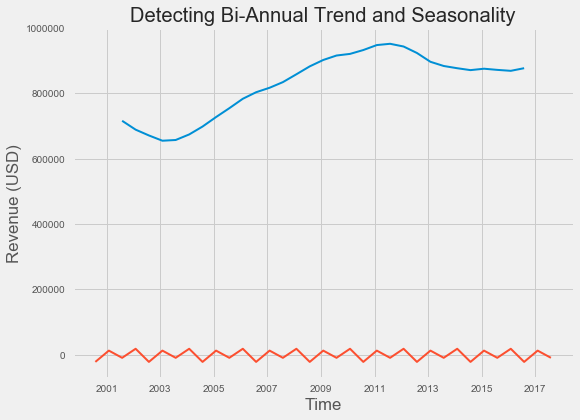

In [1241]:
decompose(bi_yearly, "Bi-Annual")

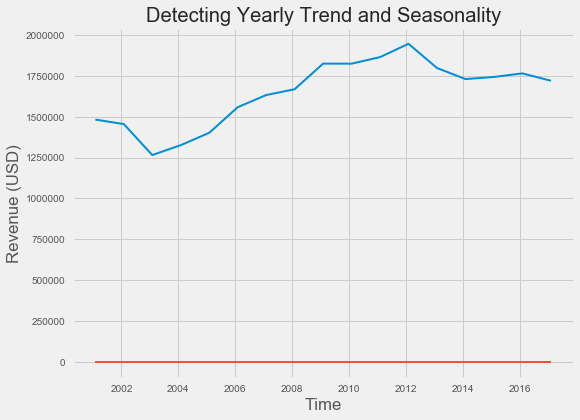

In [1242]:
decompose(yearly, "Yearly")

Let's start with bi-yearly and see how it works with the different models

# Is the Data Stationary?

In order to run a time series model, the data needs to be stationary. Let's run some tests on it to see if this data is stationary!

Below, I plotted the rolling average with a 12 month window to see the trend, and the standard deviation to see the variance. Looks like the variance is not uniform, and there is an upward trend.

In [1243]:
bi_yearly.head()

,total_revenue
index,
2000-07-31,740761.53
2001-01-31,741900.96
2001-07-31,696383.66
2002-01-31,758695.78
2002-07-31,595711.98


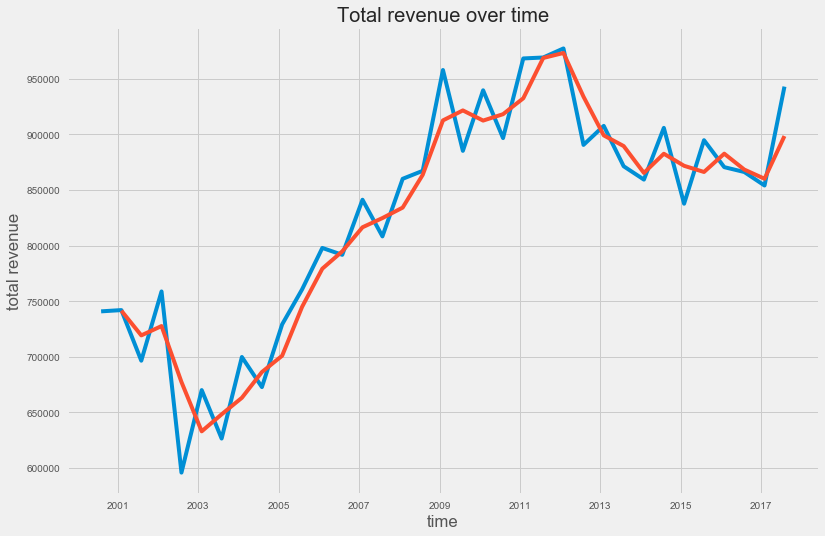

In [1244]:
#calculate rolling average with window of 12 (1 year) to spot trends
rolling_mean = bi_yearly.rolling(window=2).mean()
rolling_std = bi_yearly.rolling(window=2).std()
plt.figure(figsize=(12,8))
plt.plot(bi_yearly)
plt.plot(rolling_mean)
plt.xlabel('time')
plt.ylabel('total revenue')
plt.title('Total revenue over time')
# plt.legend(loc='best')

Here the histogram of the revenue is not normal but skewed right, which contributes to indication that the data is not stationary.

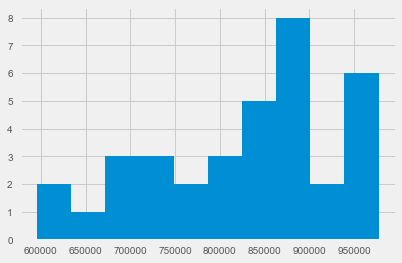

In [1246]:
plt.hist(bi_yearly.total_revenue, bins = 10);

#skewed right, not normal

To know once and for all if the data is stationary, let's perform a dickey-fuller test. 


- null hypothesis - has a unit root and is NOT stationary
- alternate - does not have a unit root and is stationary
- alpha = 0.05

The test shows that the p-value > 0.05 which means that we should accept the null hypothesis, that the time series is NOT stationary.


In [1247]:
def dkf(series):
    series.dropna(inplace=True)
    dkf_results = adfuller(series)
    return dkf_results[1]

print('p-value:', dkf(bi_yearly.total_revenue))

p-value: 0.814536069903


# Train Test Split

Now that we have our data, let's run a train test split, keeping the order of the data since we are working with a time series. 

To set up train test split, we have to upsample to monthly so there are enough samples to work with.

In [1248]:
bi_yearly.shape

(35, 1)

In [1252]:
#upsample the bi-annual data
upsample = bi_yearly.resample("M")
monthly_upsample = upsample.interpolate(method='spline', order =2)

In [1253]:
#create features
monthly_upsample['first_diff'] = monthly_upsample.diff()
monthly_upsample['seasonal_diff'] = monthly_upsample.total_revenue - monthly_upsample.total_revenue.shift(6)
monthly_upsample['first_seasonal_diff'] = monthly_upsample.seasonal_diff.diff()

In [1254]:
#set length
tts_cutoff = round(monthly_upsample.shape[0] *.75)

train = pd.DataFrame(monthly_upsample[:tts_cutoff])
test = pd.DataFrame(monthly_upsample[tts_cutoff:])

print(tts_cutoff)

154


# Finding Stationarity

Since the data is not stationary, it's time to find stationarity by taking the first diff, the seasonal diff, and the first seasonal diff. 

In [1255]:
train.shape

(154, 4)

In [1256]:
first_diff_pval = dkf(train.first_diff)
seasonal_diff_pval = dkf(train.seasonal_diff)
seasonal_first_diff_pval = dkf(train.first_seasonal_diff)

print('p-value of original:', dkf(total_revenue))
print('p-value of first diff:', first_diff_pval)
print('p-value of second diff:', second_diff_pval)
print('p-value of seasonal diff:', seasonal_diff_pval)
print('p-value of seasonal first diff:', seasonal_first_diff_pval)

p-value of original: 0.820704190998
p-value of first diff: 0.0193794201359
p-value of second diff: 0.0167171973911
p-value of seasonal diff: 0.0823593356836
p-value of seasonal first diff: 2.79361098419e-06


So we found that taking the first difference and or first difference of the seasonal difference makes it stationary. Since we see a strong seasonal signal, let's check acf and pacf plots of each to determine if we should run a Autoregressive model or a Moving Average model, or both!

In [1257]:
def correlation_plots(name, series, num_lags = 72):
    print(name +' plot')
    plot_acf(series, lags = num_lags);
    plot_pacf(series, lags = num_lags);

original data plot


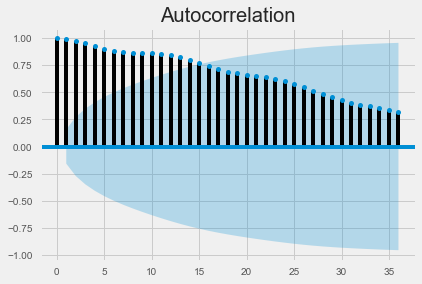

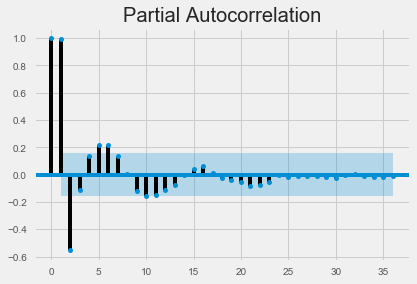

In [1258]:
correlation_plots('original data', train.total_revenue, num_lags = 36)

first diff plot


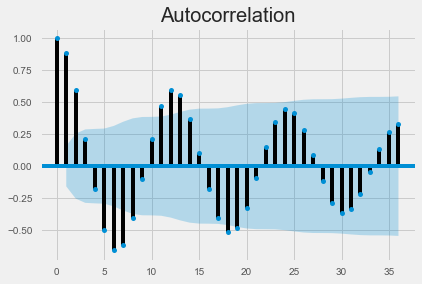

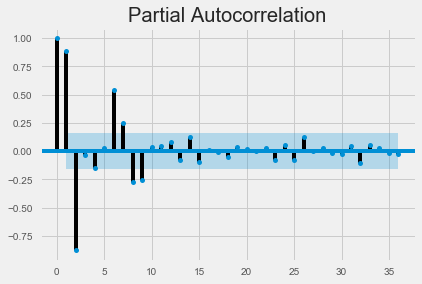

In [1259]:
correlation_plots('first diff', train['first_diff'], num_lags = 36)

first seasonal diff plot


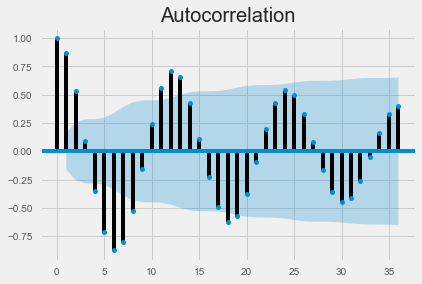

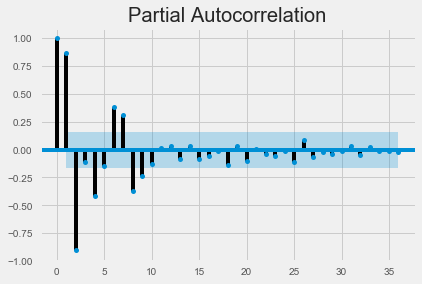

In [1260]:
correlation_plots('first seasonal diff', train['first_seasonal_diff'], 36)

# Modeling w/ARMA

In [1261]:
#fit_score function takes in a time series (ts), parameter for AR (p), parameter for MA (q), 
#and fits, scores, and plots an ARMA model. It returns the fitted values of the ARMA model

#train, test should already be differenced

def fit_score_predict(train, test, p, q, tts_cutoff):
    #fit model
    train_series = train.dropna().values
    model = ARMA(train_series, (p,q)).fit()
    
    #print r2 score
    r2 = r2_score(train_series, model.fittedvalues)
    residuals = model.resid
    print('mean_resid', residuals.mean())
    print('r2_score', r2)
    
    #print model summary
    print(model.summary())
    
    #make predictions
    predictions = model.predict(start=tts_cutoff, end = tts_cutoff+test.shape[0]-2)
    
    #print actual vs fitted values
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(train.index, train, lw=2, color='grey', ls='dashed', label = 'train actual')
    ax.plot(train.index, model.fittedvalues, lw=2, color='darkred', label = 'fitted values')
    ax.plot(test.index, test, lw = 2, color='blue', ls='dashed', label = 'test actual')
    ax.plot(test.index, predictions, label = 'test prediction')
    plt.xlabel('time')
    plt.ylabel('values')
    plt.legend(loc='best')
    plt.title('Actual vs Predicted values for ARMA model')
    plt.show()
    
    #plot acf and pacf of residuals
    fig, ax = plt.subplots(figsize=(9,5))
    plt.plot(residuals)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(9,5))
    plot_acf(residuals, lags=30, ax=ax)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(9,5))
    plot_pacf(residuals, lags=30, ax=ax)
    plt.show()
    
    return model

mean_resid -20.495639059
r2_score 0.787037471931
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  153
Model:                     ARMA(1, 0)   Log Likelihood               -1523.024
Method:                       css-mle   S.D. of innovations           5066.895
Date:                Thu, 11 Jan 2018   AIC                           3052.049
Time:                        09:29:32   BIC                           3061.140
Sample:                             0   HQIC                          3055.742
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        778.6947   3385.105      0.230      0.818   -5855.990    7413.379
ar.L1.y        0.8846      0.036     24.325      0.000       0.813       0.956
   

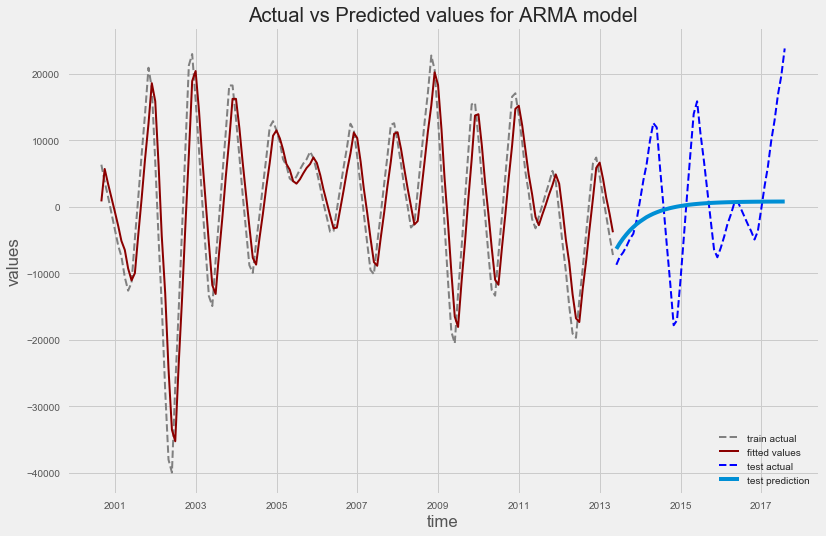

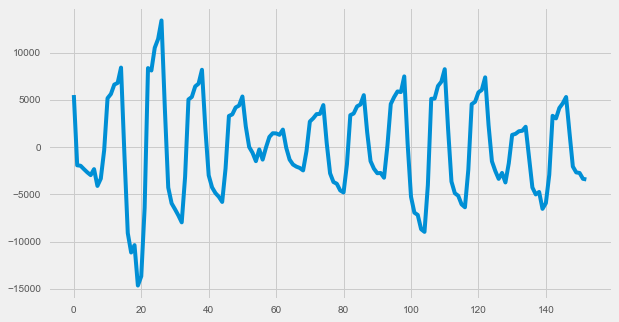

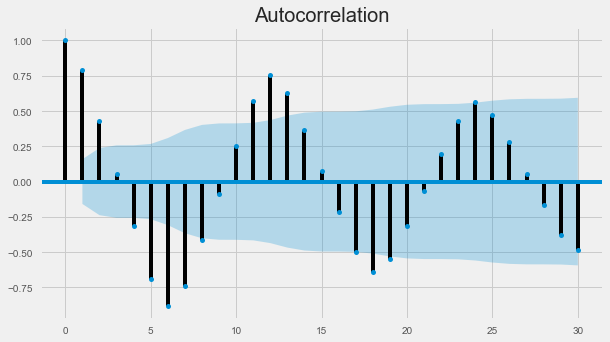

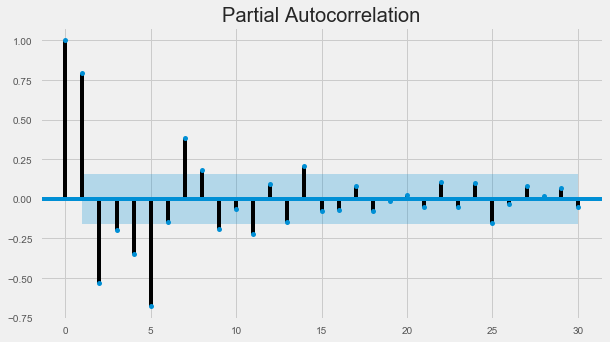

In [1262]:
ar1 = fit_score_predict(train.first_diff, test.first_diff, 1, 0, tts_cutoff)

mean_resid 16.7771303763
r2_score 0.959046464514
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  153
Model:                     ARMA(2, 0)   Log Likelihood               -1395.914
Method:                       css-mle   S.D. of innovations           2184.335
Date:                Thu, 11 Jan 2018   AIC                           2799.829
Time:                        09:29:34   BIC                           2811.950
Sample:                             0   HQIC                          2804.753
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1004.8945    837.820      1.199      0.232    -637.202    2646.991
ar.L1.y        1.6831      0.034     50.153      0.000       1.617       1.749
ar.

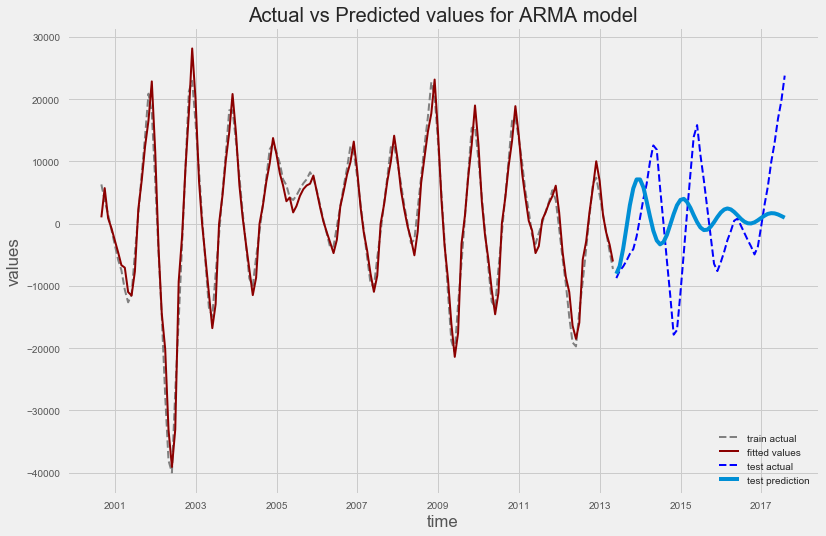

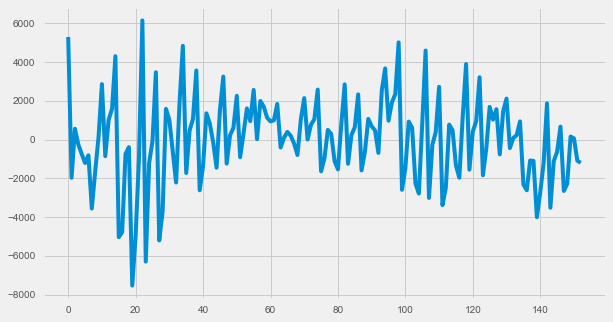

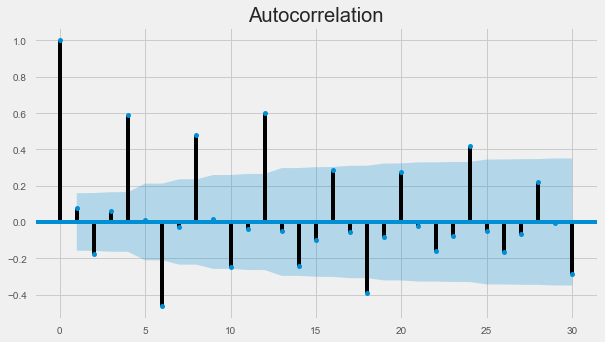

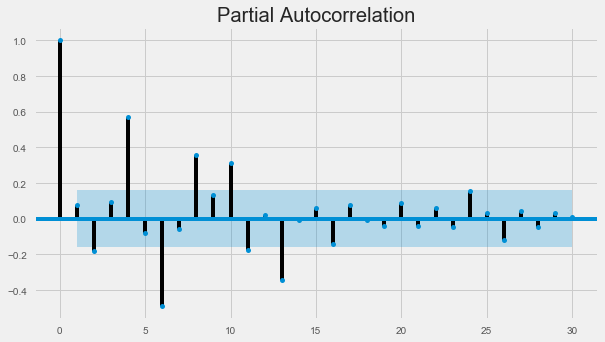

In [1263]:
ar2 = fit_score_predict(train.first_diff, test.first_diff, 2, 0, tts_cutoff)

mean_resid -21.5724657602
r2_score 0.903622948181
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  153
Model:                     ARMA(1, 1)   Log Likelihood               -1462.408
Method:                       css-mle   S.D. of innovations           3392.585
Date:                Thu, 11 Jan 2018   AIC                           2932.816
Time:                        09:29:36   BIC                           2944.938
Sample:                             0   HQIC                          2937.740
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1004.8945   3138.716      0.320      0.749   -5146.876    7156.665
ar.L1.y        0.8547      0.041     20.730      0.000       0.774       0.936
ma

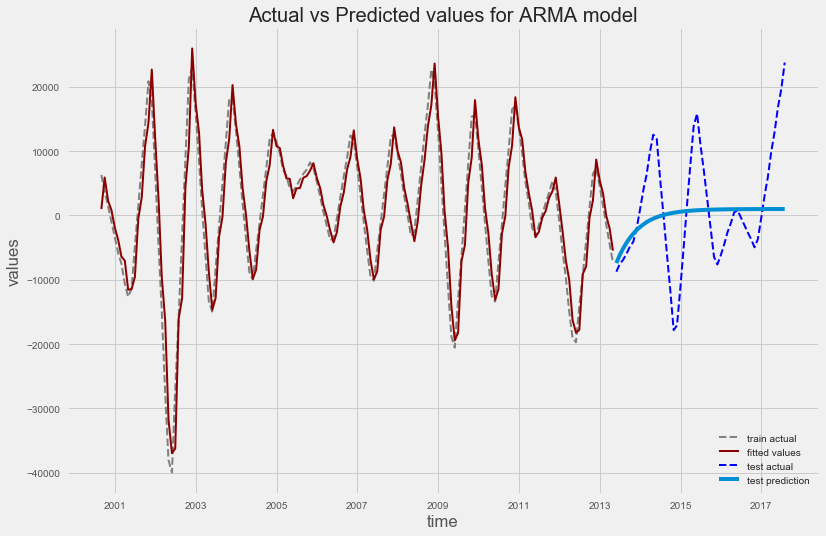

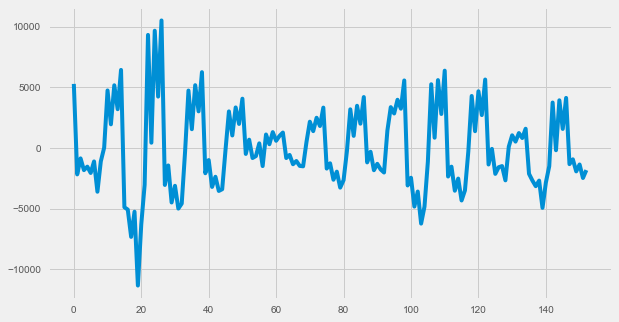

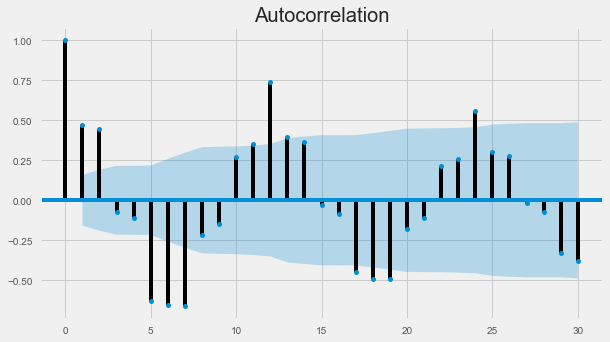

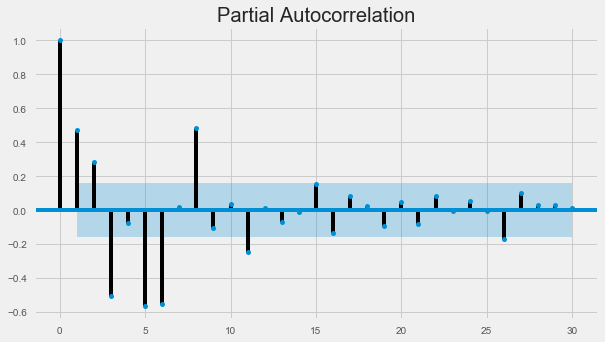

In [1264]:
ar1ma1 = fit_score_predict(train.first_diff, test.first_diff, 1, 1, tts_cutoff)

mean_resid 15.1609718962
r2_score 0.959666021178
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  153
Model:                     ARMA(2, 1)   Log Likelihood               -1394.736
Method:                       css-mle   S.D. of innovations           2166.959
Date:                Thu, 11 Jan 2018   AIC                           2799.472
Time:                        09:29:38   BIC                           2814.624
Sample:                             0   HQIC                          2805.627
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1004.8945    955.517      1.052      0.295    -867.885    2877.674
ar.L1.y        1.6512      0.044     37.890      0.000       1.566       1.737
ar.

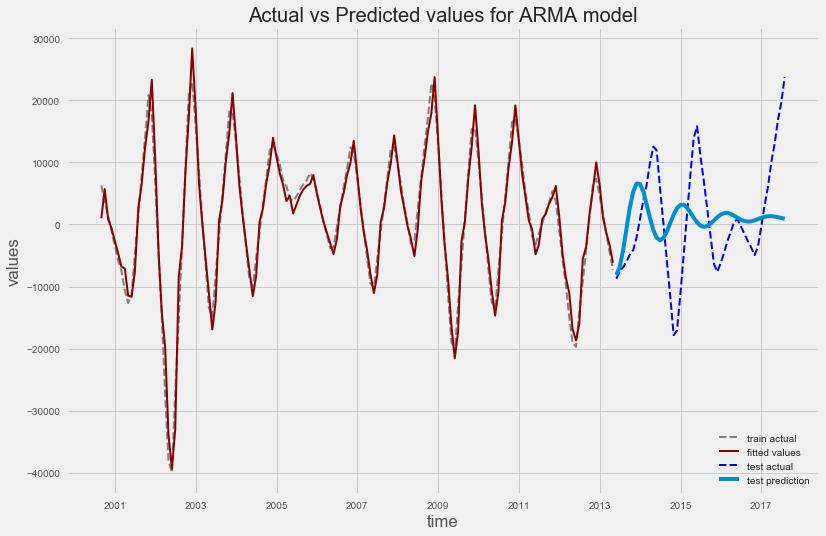

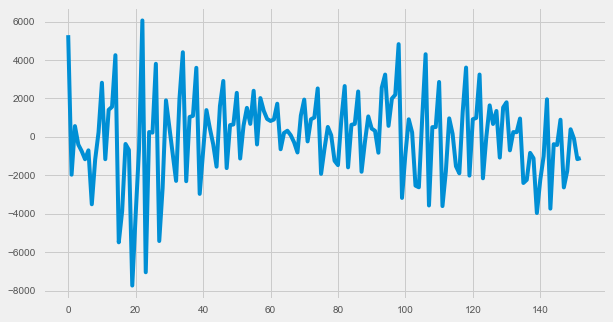

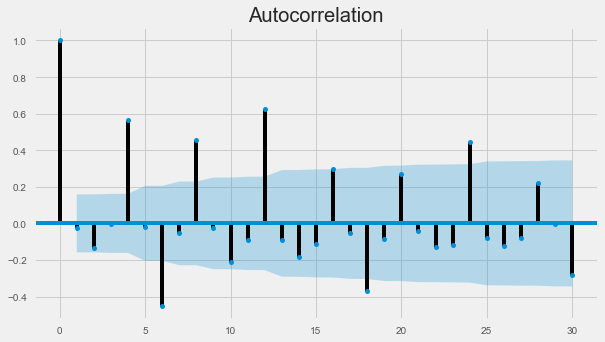

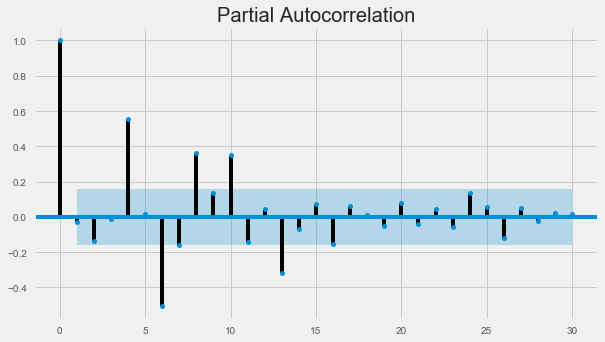

In [1265]:
ar2ma1 = fit_score_predict(train.first_diff, test.first_diff, 2, 1, tts_cutoff)

It looks like the best r2_score and AIC score is from using first_seasonal_difference with AR =2 and MA =1. I have a feeling that this could lead to overfitting but let's try to make some predictions and look at the rmse.

In [1266]:
#let's plot the predictions 

def plot_total_revenue(model, train, test, cutoff):
    predictions = model.predict(start = cutoff, end = cutoff+test.shape[0]-2)
    fv_total_rev = train[0]+np.cumsum(model.fittedvalues)
    pred_total_rev = train[-1]+np.cumsum(predictions)
    
    #rmse
    rmse = np.sqrt(mean_squared_error(test, pred_total_rev))
    model_residuals = test - pred_total_rev
    print('rmse:', rmse)
    
    #plot
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(train.index[:-1], fv_total_rev, label = 'train fitted values')
    ax.plot(train.index, train, label = 'train actual')
    ax.plot(test.index, test, label = 'test actual')
    ax.plot(test.index, pred_total_rev, label = 'test predicted')
    plt.title("Total Revenue From 2000-2017")
    plt.xlabel("Time")
    plt.ylabel("Revenue ($USD)")
    plt.legend(loc='best')    
    

rmse: 24545.1488312


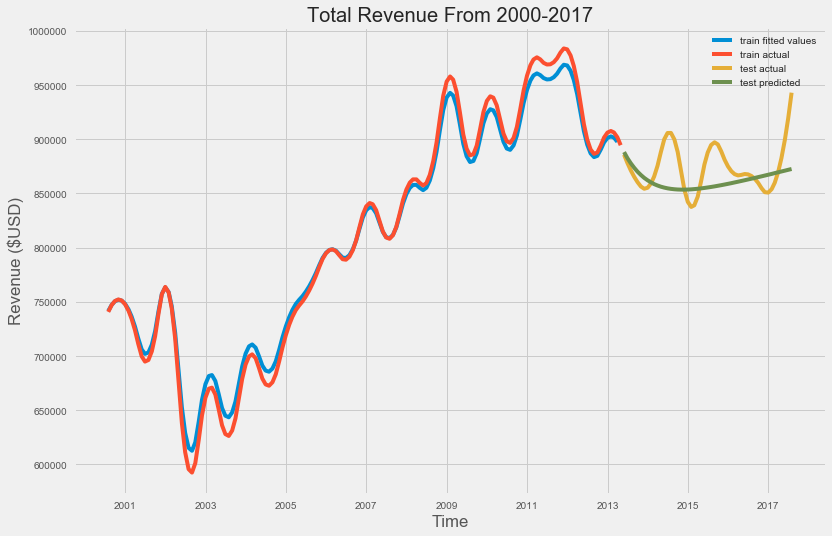

In [1267]:
plot_total_revenue(ar1, train.total_revenue, test.total_revenue, tts_cutoff)

rmse: 46355.3867612


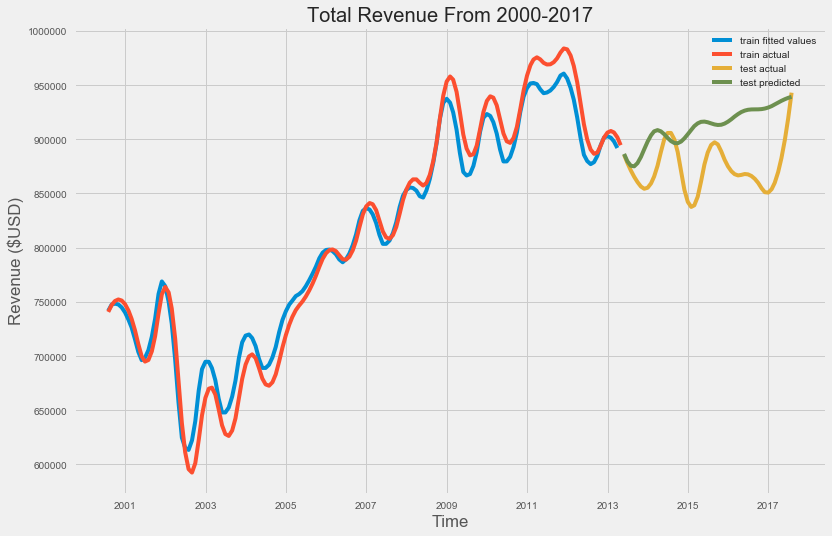

In [1268]:
plot_total_revenue(ar2, train.total_revenue, test.total_revenue, tts_cutoff)

rmse: 22388.8588496


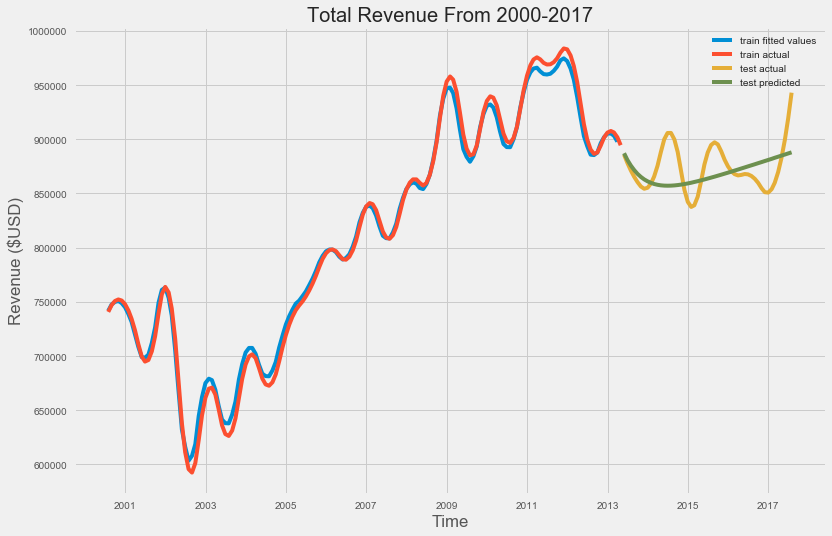

In [1269]:
plot_total_revenue(ar1ma1, train.total_revenue, test.total_revenue, tts_cutoff)

rmse: 45155.4250215


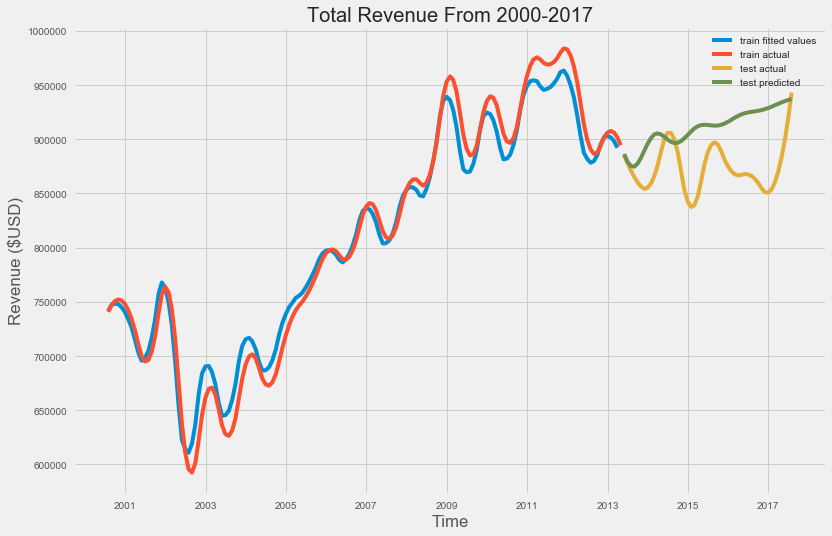

In [1270]:
 plot_total_revenue(ar2ma1, train.total_revenue, test.total_revenue, tts_cutoff)

# Modeling with Sarimax

In [1271]:
import statsmodels.api as sm
data = train.first_seasonal_diff
model = sm.tsa.statespace.SARIMAX(data, order=(2,0,1), seasonal_order=(2,0,0,6))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:               first_seasonal_diff   No. Observations:                  147
Model:             SARIMAX(2, 0, 1)x(2, 0, 0, 6)   Log Likelihood               -1286.138
Date:                           Thu, 11 Jan 2018   AIC                           2584.276
Time:                                   09:30:38   BIC                           2602.218
Sample:                               02-28-2001   HQIC                          2591.566
                                    - 04-30-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7734      0.045     39.410      0.000       1.685       1.862
ar.L2         -0.8472      0.046    -18.396

/Users/htn211/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1272]:
predictions_sarimax = results.forecast(test.first_seasonal_diff.shape[0])
fv = results.fittedvalues

In [1273]:
# plt.plot(train.total_revenue.index, results.fittedvalues)
# plt.plot(train.total_revenue.index, train.total_revenue)
# plt.plot(test.total_revenue.index, predictions_sarimax)
# plt.plot(test.total_revenue.index, test.total_revenue)

# rmse = np.sqrt(mean_squared_error(test.total_revenue,predictions_sarimax))
# print(rmse)

17867.6490696
0.99072647289


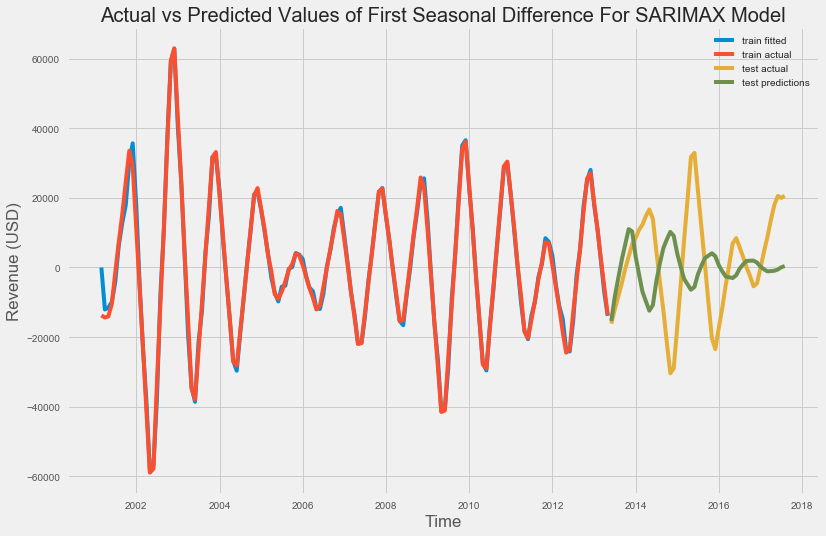

In [1274]:
plt.figure(figsize=(12,8))
plt.plot(train.first_seasonal_diff.index, results.fittedvalues, label = 'train fitted')
plt.plot(train.first_seasonal_diff.index, train.first_seasonal_diff, label = 'train actual')
plt.plot(test.first_seasonal_diff.index, test.first_seasonal_diff, label = 'test actual')
plt.plot(test.first_seasonal_diff.index, predictions_sarimax, label = 'test predictions')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')
plt.legend(loc='best')
plt.title('Actual vs Predicted Values of First Seasonal Difference For SARIMAX Model')
r2 = r2_score(train.first_seasonal_diff, fv)
rmse = np.sqrt(mean_squared_error(test.first_seasonal_diff,predictions_sarimax))
print(rmse)
print(r2)

In [1275]:
#to get full predictions
true_sdiff_train = train.seasonal_diff[0]+np.cumsum(results.fittedvalues)
true_sdiff_test = test.seasonal_diff[0] + np.cumsum(predictions)

In [1276]:
true_original_values_train = []
for i in range(0, train.seasonal_diff.shape[0]-2):
    total_rev = true_sdiff_train[i] + train.total_revenue[i]
    true_original_values_train.append(total_rev)
len(true_original_values_train)


146

In [1277]:
true_original_values_test = []
for i in range(0, test.seasonal_diff.shape[0]):
    total_rev = true_sdiff_test[i] + test.total_revenue[i]
    true_original_values_test.append(total_rev)
len(true_original_values_test)
len(test.total_revenue.index)

51

rmse 48759.3938512
r2 0.979825251067


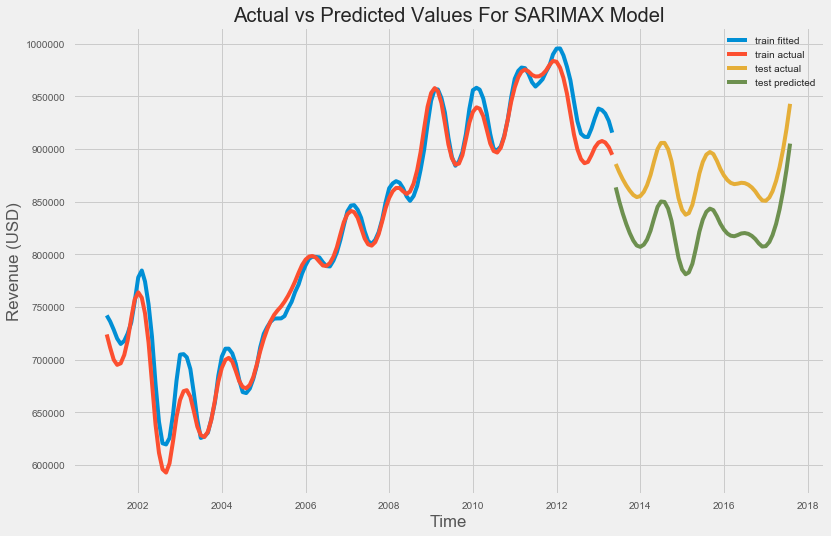

In [1278]:
plt.figure(figsize=(12,8))
plt.plot(train.total_revenue.index[8:], true_original_values_train, label = 'train fitted')
plt.plot(train.total_revenue.index[8:], train.total_revenue[8:], label = 'train actual')
plt.plot(test.total_revenue.index, test.total_revenue, label = 'test actual')
plt.plot(test.total_revenue.index, true_original_values_test, label = 'test predicted')
plt.xlabel('Time')
plt.ylabel('Revenue (USD)')
plt.legend(loc='best')
plt.title('Actual vs Predicted Values For SARIMAX Model')

rmse = np.sqrt(mean_squared_error(test.total_revenue, true_original_values_test))
print('rmse',rmse)
r2 = r2_score(train.total_revenue[8:], true_original_values_train)
print('r2', r2)

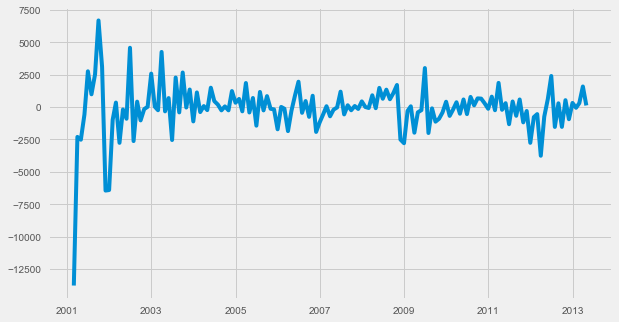

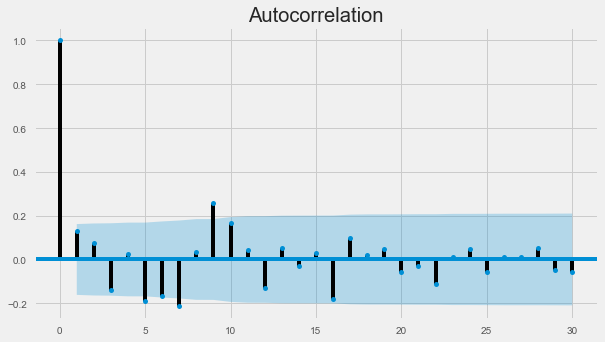

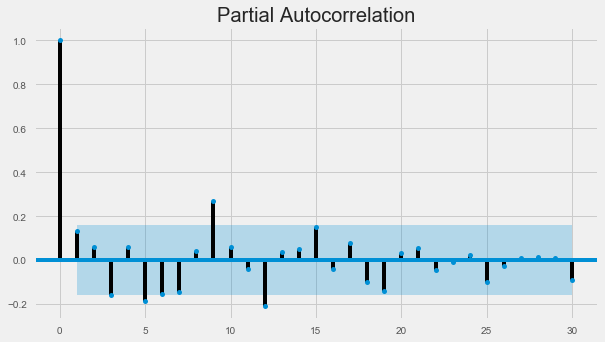

residuals mean 15.35632032427111


In [1280]:
residuals = results.resid
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(residuals)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

print('residuals mean',residuals[12:].mean())

# Modeling with Facebook's Prophet

Let's see if Facebook's Prophet can do any better! First, we'll have to do some preprocessing so our dataframe can be fed into Prophet.

In [1281]:
fb_train = pd.DataFrame()
fb_train['y_orig'] = train['total_revenue']
fb_train['y'] = train.first_diff
fb_train['ds'] = train.index
fb_train.dropna(inplace=True)
fb_train.reset_index(drop = True, inplace = True)
fb_train = fb_train[['ds', 'y', 'y_orig']]

In [1282]:
fb_train.head()

,ds,y,y_orig
0,2000-08-31,6299.048042,747060.578042
1,2000-09-30,3739.437210,750800.015252
2,2000-10-31,1429.235885,752229.251137
3,2000-11-30,-973.174206,751256.076930
4,2000-12-31,-3440.462578,747815.614352


In [1283]:
fbp = Prophet()
fbp.fit(fb_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [1284]:
future_data = fbp.make_future_dataframe(periods = 51, freq = 'm')
forecast_data = fbp.predict(future_data)

In [1285]:
forecast_data = forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [1286]:
forecast_data.tail()

,ds,yhat,yhat_lower,yhat_upper
199,2017-03-31,-7317.039765,-16114.496259,1513.651063
200,2017-04-30,-11919.285435,-20524.581862,-3024.176624
201,2017-05-31,-12998.284407,-21891.401176,-4078.966270
202,2017-06-30,-7506.175038,-15731.883588,1608.810487
203,2017-07-31,-2469.614445,-11437.669060,6357.546937


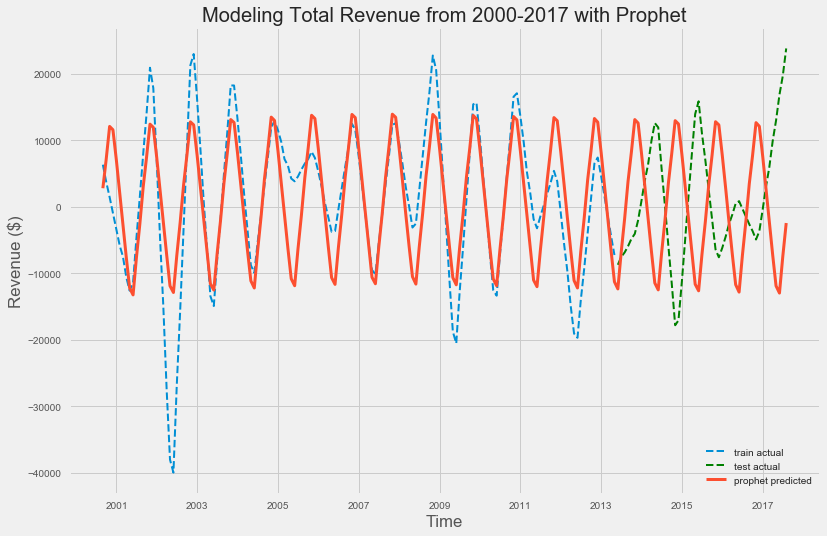

In [1287]:
plt.figure(figsize=(12,8))
plt.plot(fb_train.ds, fb_train.y, lw = 2, ls = 'dashed', label = 'train actual')
plt.plot(test.index, test.first_diff, color = 'green', lw = 2, ls = 'dashed', label = 'test actual')
plt.plot(forecast_data.ds, forecast_data.yhat, lw = 3, label = 'prophet predicted')
plt.legend(loc = 'best')
plt.title('Modeling Total Revenue from 2000-2017 with Prophet')
plt.xlabel('Time')
plt.ylabel("Revenue ($)");


# Next Steps

There are quite a few things that I'd still want to explore in this dataset:
1. Consider other types of transformations like:
    - How to account for deflation 
    - Logarithmic transform
    - Seasonal adjustment
2. Run an LSTM Neural Nets model
3. Run a regression model with more features